# CESM2 Large Ensemble 2 Investiagtion

Daily files are located under `/glade/campaign/cgd/cesm/CESM2-LE/timeseries/atm/proc/tseries/day_1/WSPDSRFAV/*` on the NCAR server.

__Variables analyzed__
- `WSPDSRFAV`: Horizontal total wind speed average at the surface [$m \ s^{-1}$]
- _WSPDSRFAV anomaly_: artificially constructed according to $x_i-\bar{x}_{\text{time}}$

For this study, anomalies are calculated relative to the historical reference period, 1978-2014. Thus $\bar{x}_{\text{time}} = \bar{x}_{1978-2014}$

In [1]:
import matplotlib.pyplot as plt
from matplotlib import colors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter
import nc_time_axis
import numpy as np
import pandas as pd
import pwlf
import xarray as xr
import cf_xarray as cfxr   # to use cf_xarray attributes
import metpy.calc as mpcalc  # geostrophic wind
from metpy.units import units
import regionmask
from glob import glob
import scienceplots
import string
import scipy
%matplotlib inline
plt.style.use(["nature", "notebook"])

xr.set_options(keep_attrs=True)
%load_ext rich
from rich import print  # pretty printing
from tqdm import tqdm  # progress bar
import warnings  # deal with warnings

# To access collection
import dask
import intake
from ncar_jobqueue import NCARCluster
from dask_jobqueue import PBSCluster
from dask.distributed import Client

# Play nice with CMIP6 data
import xclim.ensembles as ensembles

## Helper functions

Issue: this is very slow for some reason

In [2]:
# Mask using regionmask
def mask_data(data, map, regions: None, drop=False, reverse=False):
    """Mask xarray data based on region names

    Args:
        data (xarray dataset): xarray dataset to mask
        map (regionmask): regionmask object
        regions (list or None): list of region names to mask. if None, all regions are taken. Defaults to None.
        drop (bool, optional): Whether to drop when masking. Defaults to False.
        reverse (bool, optional): Whether to mask the inverse of the regions. Defaults to False.

    Returns:
        xarray dataset: masked dataset
    """
    # Load the region mask
    mask = map.mask(data)
    # Extract keys for the region
    id_dict = map.region_ids
    # Get region names
    if regions is None:
        names = id_dict.keys()
    else:
        # Coerce region names to uppercase
        regions_upper = [region.upper() for region in regions]
        names = [name for name in id_dict.keys() if str(name).upper() in regions_upper]
        assert len(names) == len(regions), 'Not enough regions found'
    # Get the key for the regions
    keys = [id_dict[name] for name in names]
    # Apply the mask to the data
    if reverse:
        masked_data = data.where(~mask.isin(keys), drop=drop)
    else:
        masked_data = data.where(mask.isin(keys), drop=drop)
    return masked_data

# P-value for xarray linear regression
def p_val(r, n,  lat, lon):
    var = np.diag(r.polyfit_covariance.sel(lat=lat, lon=lon))
    #The standard error of the parameter estimates from the variance-covariance matrix is the square root of the diagonal values
    std_err = np.sqrt(var)
    # std_err = std/np.sqrt(n)
    t = r.sel(lat=lat, lon=lon).polyfit_coefficients.values/std_err
    # Degrees of freedom = n-2 (fit two parameters)
    df = n-2
    # Only need to test for slop (degree=1)
    t = t[1]
    return scipy.stats.t.sf(abs(t), df=df)

# Seasonal averages from monthly data
def season_mean(ds, calendar="standard"):
    # Make a DataArray with the number of days in each month, size = len(time)
    month_length = ds.time.dt.days_in_month

    # Calculate the weights by grouping by 'time.season'
    weights = (
        month_length.groupby("time.season") / month_length.groupby("time.season").sum()
    )

    # Test that the sum of the weights for each season is 1.0
    np.testing.assert_allclose(weights.groupby("time.season").sum().values, np.ones(4))

    # Calculate the weighted average
    return (ds * weights).groupby("time.season").sum(dim="time").reindex(season =['DJF','MAM','JJA','SON'])

# List of all East coast states
east_states = [
    'maine',
    'new hampshire',
    'vermont',
    'massachusetts',
    'rhode island',
    'connecticut',
    'new york',
    'delaware',
    'maryland',
    'new jersey',
    'pennsylvania',
    'west virginia',
    'virginia',
    'north carolina',
    'south carolina',
    'georgia',
    'florida',
]

# Regions to mask
us_states = regionmask.defined_regions.natural_earth_v5_0_0.us_states_50
land_region = regionmask.defined_regions.natural_earth_v5_0_0.land_110  # Land has value 0
countries = regionmask.defined_regions.natural_earth_v5_0_0.countries_110

## Spin up Dask cluster

In [ ]:
# Create our NCAR Cluster - which uses PBSCluster under the hood
num_jobs = 5

cluster = PBSCluster(
    job_name='valencig_dask',
    cores=1,  # Total number of cores per job
    memory='10GB', # Total amount of memory per job
    processes=32, # Number of Python processes per job
    interface='hsn0', # Network interface to use like eth0 or ib0
    queue='main',
    walltime='01:00:00',
    # resource-spec: select=1:ncpus=128:mem=235GB
    local_directory = '/glade/u/home/valencig/spilled/',
    log_directory = '/glade/u/home/valencig/worker-logs/',
)

# cluster = NCARCluster(threads_per_worker=1)

# Spin up workers
cluster.scale(num_jobs)

# Assign the cluster to our Client
client = Client(cluster)

# Change your url to the dask dashboard so you can see it
# dask.config.set({'distributed.dashboard.link':'https://jupyterhub.hpc.ucar.edu/stable/user/${USER}/proxy/${port}/status'})

# Block progress until workers have spawned
client.wait_for_workers(num_jobs)
client

## Create ensemble

### Get simulation names

- `smbb`: smoothed biomass burning (more info [here](https://www.cesm.ucar.edu/community-projects/lens2))
- `cmip6`: classic CMIP6 forcings

In [ ]:
# Get list of all files
all_files = glob('/glade/campaign/cgd/cesm/CESM2-LE/timeseries/atm/proc/tseries/day_1/WSPDSRFAV/*')
# Simulation runs
simulation_names = set([f.split('.')[2] for f in all_files])
simulation_names

### Load simulations

In [ ]:
# Create dict to store all variants
simulations = dict()

for sim in simulation_names:
    # Extract all member numbers
    sim_files = [f for f in all_files if f.split('.')[2] == sim]
    members = list(set([f.split('.')[4] for f in sim_files]))
    # Create list to store datasets for each member
    sim_list = []
    for member in tqdm(members, desc=f"{sim} - Loading members..."):
        # Get files for this member
        m_files = [f for f in sim_files if f.split('.')[4] == member]
        # Load dataset
        ds = xr.open_mfdataset(m_files, parallel=True)
        # Remove 2100 or 2015 for historical data (data extends to 2099)
        if 'HIST' in sim:
            sliced = ds.sel(time=slice('1978', '2014')).compute()
        elif 'SSP370' in sim:
            sliced = ds.sel(time=slice(None, '2099')).compute()
        # Expand dimension name
        sim_list.append(sliced.WSPDSRFAV)
    simulation = ensembles.create_ensemble(sim_list, realizations=members)
    yearly = simulation.groupby('time.year').mean()  # No need to store daily data
    # Add to dict
    simulations[sim] = yearly.persist().compute()  # This step is slow but speeds up later computation

## Combine simulations by forcing variant

Determine anomaly relative to 1978-2014 mean windspeeds

In [ ]:
cmip6_raw = xr.combine_by_coords([
    simulations['BHISTcmip6'].sortby('realization'),
    simulations['BSSP370cmip6'].sortby('realization')
])
smbb_raw = xr.combine_by_coords([
    simulations['BHISTsmbb'].sortby('realization'),
    simulations['BSSP370smbb'].sortby('realization')
])
forcings = dict(
    cmip6=cmip6_raw - cmip6_raw.sel(year=slice(1978, 2014)).mean('year'),
    smbb=smbb_raw - smbb_raw.sel(year=slice(1978, 2014)).mean('year'),
)

## Global

### Time series

In [ ]:
years = np.arange(1978, 2100)  # 1978-2099
# Masking regions
land_region = regionmask.defined_regions.natural_earth_v5_0_0.land_110  # Land has value 0
countries = regionmask.defined_regions.natural_earth_v5_0_0.countries_110

# Dict to store timeseries values
forcing_ts = dict()

# Make plot
fig, axes = plt.subplots(figsize=(14, 5), nrows=1, ncols=2, sharey=True, sharex=True, layout="constrained")

for i, force in enumerate(forcings.keys()):
    ax = axes[i]
    # mask to land
    land = mask_data(forcings[force], land_region, ['land'], drop=True)
    # Eliminate the planet of Hoth
    land = mask_data(land, countries, ['greenland'], reverse=True, drop=True)
    land = land.where((land['lat']>-59).compute(), drop=True)  # antarctica
    land = land.where((land['lat']<70).compute(), drop=True)  # Northern canada
    # Get timeseries
    land_ts = land.mean(['lat', 'lon'])
    # Reduce the simulation
    en_stats = ensembles.ensemble_mean_std_max_min(land_ts)['WSPDSRFAV_mean']
    rolled = en_stats.rolling(year=5, min_periods=1, center=True).mean()
    # Percentiles
    per = ensembles.ensemble_percentiles(land_ts, values=[25, 75], split=True)
    # errs = np.array([per['WSPDSRFAV_p25'], per['WSPDSRFAV_p75']])
    # Plot past
    ax.plot(years[years <= 2014], en_stats[years <= 2014], label='Historical')
    # Plot future (include 2014 so plot connects)
    ax.plot(years[years >= 2014], en_stats[years >= 2014], linewidth=2, label='Projected')
    # Other stats
    ax.plot(years, rolled, label='5-yr rolling mean')
    ax.fill_between(years, per['WSPDSRFAV_p25'], per['WSPDSRFAV_p75'], color='k', alpha=0.2)
    # Plot 1 - Options
    ax.set_title(f'CESM2LENS2 {force.upper()} Forcing')
    
# Options for both plots
for n, ax in enumerate(axes):
    ax.legend(fontsize=10)
    ax.grid(True)
    ax.set_xlabel('Year')
    ax.set_ylabel('NSWS Anomaly [m s$^{-1}$]')
    # ax.vlines(2010, -0.1, 0.1, color='k', linestyle='--')
    ax.set_xlim(years[0], years[-1])
    ax.set_ylim(-0.1, 0.06)
    # Add subplot label
    ax.text(-0.05, 1.05, f'({string.ascii_lowercase[n]})', transform=ax.transAxes, size=20)
fig.suptitle('Global Terrestrial NSWS', fontsize=20)

# Save figure
plt.savefig('figures/cesm2lens2_time_series_global.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

### Spatial plot

In [ ]:
fig = plt.figure(figsize=(12, 8), constrained_layout=True)
gs = fig.add_gridspec(3, 2, width_ratios=[1, 1])  # left plot spatial, right plot signifigance
n = 0  # for subplot labels
for i, force in enumerate(forcings.keys()):
    # mask to land
    land = mask_data(forcings[force], land_region, ['land'], drop=True)
    # Eliminate the planet of Hoth
    land = mask_data(land, countries, ['greenland'], reverse=True, drop=True)
    land = land.where((land['lat']>-59).compute(), drop=True)  # antarctica
    land = land.where((land['lat']<70).compute(), drop=True)  # Northern canada
    # Create axes for plotting
    h = fig.add_subplot(gs[0, i], projection=ccrs.PlateCarree())
    f = fig.add_subplot(gs[1, i], projection=ccrs.PlateCarree())
    d = fig.add_subplot(gs[2, i], projection=ccrs.PlateCarree())
    # Reduce the simulation
    en_stats = ensembles.ensemble_mean_std_max_min(land)['WSPDSRFAV_mean']
    # Get trends 
    hist_trend = (
        en_stats.sel(year=slice(None, 2014))
        .polyfit('year', deg=1, skipna=True, cov=True)
    )
    future_trend = (
        en_stats.sel(year=slice(2015, None))
        .polyfit('year', deg=1, skipna=True, cov=True)
    )
    hist_coef = hist_trend.polyfit_coefficients.sel(degree=1)*10  # decadal
    future_coef = future_trend.polyfit_coefficients.sel(degree=1)*10  # decadal
    # Plot 1 - historical plot
    im = hist_coef.plot(ax=h, vmin=-0.15, vmax=0.15, cmap='RdBu_r', transform=ccrs.PlateCarree(), add_colorbar=False)
    cb = plt.colorbar(im, orientation="vertical", pad=0.01, extend='both', shrink=0.7)
    cb.ax.tick_params(labelsize=10)
    cb.set_label(label='Decadal Trend [m/s]', fontsize=12)
    h.set_title(f'{force.upper()} Forcing - Historical')
    hist_trend = hist_trend.coarsen(lon=5, lat=5, boundary='pad').mean()
    for lat in hist_trend.lat:
        for lon in hist_trend.lon:
            if p_val(hist_trend, 37, lat, lon) < 0.05:  # 37 years 1978-2014
                h.plot(lon, lat, 'ko', transform=ccrs.PlateCarree(), markersize=0.5)
    # Plot 2 - future plot
    im = future_coef.plot(ax=f, vmin=-0.15, vmax=0.15, cmap='RdBu_r', transform=ccrs.PlateCarree(), add_colorbar=False)
    cb = plt.colorbar(im, orientation="vertical", pad=0.01, extend='both', shrink=0.7)
    cb.ax.tick_params(labelsize=10)
    cb.set_label(label='Decadal Trend [m/s]', fontsize=12)
    f.set_title(f'{force.upper()} Forcing - Projected')
    future_trend = future_trend.coarsen(lon=5, lat=5, boundary='pad').mean()
    for lat in future_trend.lat:
        for lon in future_trend.lon:
            if p_val(future_trend, 37, lat, lon) < 0.05:  # 37 years 1978-2014
                f.plot(lon, lat, 'ko', transform=ccrs.PlateCarree(), markersize=0.5)
    # Plot 3 - Difference
    im = (future_coef-hist_coef).plot(ax=d, cmap='PiYG_r', vmin=-0.2, vmax=0.2, transform=ccrs.PlateCarree(), add_colorbar=False)
    cb = plt.colorbar(im, orientation="vertical", pad=0.01, extend='both', shrink=0.7)
    cb.ax.tick_params(labelsize=10)
    cb.set_label(label='Difference in Decadal Trend [m/s]', fontsize=12)
    d.set_title(f'{force.upper()} Forcing - Trend Difference')
    # Need to deal with covariance matrix of combined variables



    for ax in [h, f, d]:
        # Add label
        ax.text(-0.05, 1.05, f'({string.ascii_lowercase[n]})', transform=ax.transAxes, size=14)
        n += 1
        # Map options
        ax.add_feature(cfeature.COASTLINE)
        gl = ax.gridlines(
            crs=ccrs.PlateCarree(), draw_labels=True, which='both',
            linewidth=1, color='k', alpha=1, linestyle='--'
        )
        gl.right_labels = None
        gl.top_labels = None
        gl.xlines = None
        gl.ylines = None
        lon_formatter = LongitudeFormatter(zero_direction_label=True)
        lat_formatter = LatitudeFormatter()
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.yaxis.set_major_formatter(lat_formatter)
        # Increase the ticksize
        gl.xlabel_style = {'size': 10, 'color': 'k', 'rotation':30, 'ha':'right'}
        gl.ylabel_style = {'size': 10, 'color': 'k', 'weight': 'normal'}
fig.suptitle('CESM2LENS2 Decadal Trends', fontsize=20)

plt.savefig('figures/cesm2lens2_global_trend.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

## CONUS

### Time series

In [ ]:
us_states = regionmask.defined_regions.natural_earth_v5_0_0.us_states_50
years = np.arange(1978, 2100)  # 1978-2099
# Masking regions
land_region = regionmask.defined_regions.natural_earth_v5_0_0.land_110  # Land has value 0
countries = regionmask.defined_regions.natural_earth_v5_0_0.countries_110

# Make plot
fig, axes = plt.subplots(figsize=(14, 5), nrows=1, ncols=2, sharey=True, sharex=True, layout="constrained")

for i, force in enumerate(forcings.keys()):
    ax = axes[i]
    us = mask_data(forcings[force], us_states, regions=None, drop=True)
    conus = mask_data(us, us_states, ['alaska', 'hawaii'], reverse=True, drop=True)
    conus = conus.where(conus.notnull(), drop=True)
    # Get timeseries
    conus_ts = conus.mean(['lat', 'lon'])
    # Reduce the simulation
    en_stats = ensembles.ensemble_mean_std_max_min(conus_ts)['WSPDSRFAV_mean']
    rolled = en_stats.rolling(year=5, min_periods=1, center=True).mean()
    # Percentiles
    per = ensembles.ensemble_percentiles(conus_ts, values=[25, 75], split=True)
    # errs = np.array([per['WSPDSRFAV_p25'], per['WSPDSRFAV_p75']])
    # Plot past
    ax.plot(years[years <= 2014], en_stats[years <= 2014], label='Historical')
    # Plot future (include 2014 so plot connects)
    ax.plot(years[years >= 2014], en_stats[years >= 2014], linewidth=2, label='Projected')
    # Other stats
    ax.plot(years, rolled, label='5-yr rolling mean')
    ax.fill_between(years, per['WSPDSRFAV_p25'], per['WSPDSRFAV_p75'], color='k', alpha=0.2)
    # Plot 1 - Options
    ax.set_title(f'CESM2LENS2 {force.upper()} Forcing')
    
# Options for both plots
for n, ax in enumerate(axes):
    ax.legend(fontsize=10)
    ax.grid(True)
    ax.set_xlabel('Year')
    ax.set_ylabel('NSWS Anomaly [m s$^{-1}$]')
    # ax.vlines(2010, -0.5, 0.5, color='k', linestyle='--')
    ax.set_xlim(years[0], years[-1])
    ax.set_ylim(-0.4, 0.2)
    # Add subplot label
    ax.text(-0.05, 1.05, f'({string.ascii_lowercase[n]})', transform=ax.transAxes, size=20)
fig.suptitle('CONUS Terrestrial NSWS', fontsize=20)

# Save figure
plt.savefig('figures/cesm2lens2_time_series_conus.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

### Spatial plot

In [ ]:
us_states = regionmask.defined_regions.natural_earth_v5_0_0.us_states_50

fig = plt.figure(figsize=(12, 9), constrained_layout=True)
gs = fig.add_gridspec(3, 2, width_ratios=[1, 1])  # left plot spatial, right plot signifigance
n = 0  # for subplot labels
for i, force in enumerate(forcings.keys()):
    # mask to land
    us = mask_data(forcings[force], us_states, regions=None, drop=True)
    conus = mask_data(us, us_states, ['alaska', 'hawaii'], reverse=True, drop=True)
    conus = conus.where(conus.notnull(), drop=True)
    # Create axes for plotting
    h = fig.add_subplot(gs[0, i], projection=ccrs.PlateCarree())
    f = fig.add_subplot(gs[1, i], projection=ccrs.PlateCarree())
    d = fig.add_subplot(gs[2, i], projection=ccrs.PlateCarree())
    # Reduce the simulation
    en_stats = ensembles.ensemble_mean_std_max_min(conus)['WSPDSRFAV_mean']
    # Get trends 
    hist_trend = (
        en_stats.sel(year=slice(None, 2014))
        .polyfit('year', deg=1, skipna=True, cov=True)
    )
    future_trend = (
        en_stats.sel(year=slice(2015, None))
        .polyfit('year', deg=1, skipna=True, cov=True)
    )
    hist_coef = hist_trend.polyfit_coefficients.sel(degree=1)*10  # decadal
    future_coef = future_trend.polyfit_coefficients.sel(degree=1)*10  # decadal
    # Plot 1 - historical plot
    im = hist_coef.plot(ax=h, vmin=-0.15, vmax=0.15, cmap='RdBu_r', transform=ccrs.PlateCarree(), add_colorbar=False)
    cb = plt.colorbar(im, orientation="vertical", pad=0.01, extend='both', shrink=0.7)
    cb.ax.tick_params(labelsize=10)
    cb.set_label(label='Decadal Trend [m/s]', fontsize=12)
    h.set_title(f'{force.upper()} Forcing - Historical')
    for lat in hist_trend.lat:
        for lon in hist_trend.lon:
            if p_val(hist_trend, 37, lat, lon) < 0.05:  # 37 years 1978-2014
                h.plot(lon, lat, 'ko', transform=ccrs.PlateCarree(), markersize=0.75)
    # Plot 2 - future plot
    im = future_coef.plot(ax=f, vmin=-0.15, vmax=0.15, cmap='RdBu_r', transform=ccrs.PlateCarree(), add_colorbar=False)
    cb = plt.colorbar(im, orientation="vertical", pad=0.01, extend='both', shrink=0.7)
    cb.ax.tick_params(labelsize=10)
    cb.set_label(label='Decadal Trend [m/s]', fontsize=12)
    f.set_title(f'{force.upper()} Forcing - Projected')
    for lat in future_trend.lat:
        for lon in future_trend.lon:
            if p_val(future_trend, 37, lat, lon) < 0.05:  # 37 years 1978-2014
                f.plot(lon, lat, 'ko', transform=ccrs.PlateCarree(), markersize=0.75)
    # Plot 3 - Difference
    im = (future_coef-hist_coef).plot(ax=d, cmap='PiYG_r', vmin=-0.2, vmax=0.2, transform=ccrs.PlateCarree(), add_colorbar=False)
    cb = plt.colorbar(im, orientation="vertical", pad=0.01, extend='both', shrink=0.7)
    cb.ax.tick_params(labelsize=10)
    cb.set_label(label='Difference in Decadal Trend [m/s]', fontsize=12)
    d.set_title(f'{force.upper()} Forcing - Trend Difference')
    # Need to deal with covariance matrix of combined variables

    for ax in [h, f, d]:
        # Add label
        ax.text(-0.05, 1.05, f'({string.ascii_lowercase[n]})', transform=ax.transAxes, size=14)
        n += 1
        # Map options
        ax.add_feature(cfeature.STATES)
        ax.add_feature(cfeature.BORDERS)
        gl = ax.gridlines(
            crs=ccrs.PlateCarree(), draw_labels=True, which='both',
            linewidth=1, color='k', alpha=1, linestyle='--'
        )
        gl.right_labels = None
        gl.top_labels = None
        gl.xlines = None
        gl.ylines = None
        lon_formatter = LongitudeFormatter(zero_direction_label=True)
        lat_formatter = LatitudeFormatter()
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.yaxis.set_major_formatter(lat_formatter)
        # Increase the ticksize
        gl.xlabel_style = {'size': 10, 'color': 'k', 'rotation':30, 'ha':'right'}
        gl.ylabel_style = {'size': 10, 'color': 'k', 'weight': 'normal'}
fig.suptitle('CESM2LENS2 CONUS Decadal Trends', fontsize=20)

plt.savefig('figures/cesm2lens2_conus_trend.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

## Monthly Investigation

You may need to restart the dask cluster to load files in parallel.

### Load Monthly Data

In [ ]:
# Get list of all files
mon_files = glob('/glade/campaign/cgd/cesm/CESM2-LE/timeseries/atm/proc/tseries/month_1/WSPDSRFAV/*')
# Simulation runs
simulation_names = set([f.split('.')[2] for f in mon_files])
# Create dict to store all variants
mon_simulations = dict()

for sim in simulation_names:
    # Extract all member numbers
    sim_files = [f for f in mon_files if f.split('.')[2] == sim]
    members = list(set([f.split('.')[4] for f in sim_files]))
    # Create list to store datasets for each member
    sim_list = []
    for member in tqdm(members, desc=f"{sim} - Loading members..."):
        # Get files for this member
        m_files = [f for f in sim_files if f.split('.')[4] == member]
        # Load dataset
        ds = xr.open_mfdataset(m_files)
        # Remove 2100 or 2015 for historical data (data extends to 2099)
        if 'HIST' in sim:
            sliced = ds.sel(time=slice('1978', '2014')).compute()
        elif 'SSP370' in sim:
            sliced = ds.sel(time=slice(None, '2099')).compute()
        # Expand dimension name
        sim_list.append(sliced.WSPDSRFAV)
    simulation = ensembles.create_ensemble(sim_list, realizations=members)
    # monthly = simulation.resample(time="M").mean()  # No need to store daily data
    # Add to dict
    mon_simulations[sim] = simulation # This step is slow but speeds up later computation

### Combine by Forcing Variant

In [ ]:
cmip6_raw = xr.combine_by_coords([
    mon_simulations['BHISTcmip6'].sortby('realization'),
    mon_simulations['BSSP370cmip6'].sortby('realization')
])
smbb_raw = xr.combine_by_coords([
    mon_simulations['BHISTsmbb'].sortby('realization'),
    mon_simulations['BSSP370smbb'].sortby('realization')
])
mon_forcings = dict(
    cmip6=cmip6_raw - cmip6_raw.sel(time=slice('1978', '2014')).mean('time'),
    smbb=smbb_raw - smbb_raw.sel(time=slice('1978', '2014')).mean('time'),
)

### CONUS Monthly

In [ ]:
us_states = regionmask.defined_regions.natural_earth_v5_0_0.us_states_50
years = np.arange(1978, 2100)  # 1978-2099
# Masking regions
land_region = regionmask.defined_regions.natural_earth_v5_0_0.land_110  # Land has value 0
countries = regionmask.defined_regions.natural_earth_v5_0_0.countries_110

# Make plot
fig, axes = plt.subplots(figsize=(14, 5), nrows=1, ncols=2, sharey=True, sharex=True, layout="constrained")

for i, force in enumerate(mon_forcings.keys()):
    ax = axes[i]
    us = mask_data(mon_forcings[force], us_states, regions=None, drop=True)
    conus = mask_data(us, us_states, ['alaska', 'hawaii'], reverse=True, drop=True)
    conus = conus.where(conus.notnull(), drop=True)
    # Get time series
    conus_ts = conus.WSPDSRFAV.sel(time=slice('2015', '2100'))
    # Get 10 year chunks
    for i, years in enumerate(np.arange(2020, 2100, 10)):
        start, stop = str(years), str(years+10)
        monthly = conus_ts.sel(time=slice(start, stop)).groupby('time.month').mean().mean(['lat', 'lon', 'realization'])
        monthly.plot(ax=ax, label=f'{start}-{stop}', color='k', alpha=0.1*(i+1))
    # Plot 1 - Options
    ax.set_title(f'CESM2LENS2 {force.upper()} Forcing')
    
# Options for both plots
for n, ax in enumerate(axes):
    ax.legend(fontsize=10)
    ax.grid(True)
    ax.set_xlabel('Month')
    ax.set_ylabel('NSWS Anomaly [m s$^{-1}$]')
    # ax.vlines(2010, -0.5, 0.5, color='k', linestyle='--')
    # ax.set_xlim(years[0], years[-1])
    # ax.set_ylim(-0.4, 0.2)
    ax.set_xticks(np.arange(1, 13))
    ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    # Add subplot label
    ax.text(-0.05, 1.05, f'({string.ascii_lowercase[n]})', transform=ax.transAxes, size=20)

fig.suptitle('CONUS Terrestrial NSWS', fontsize=20)

# Save figure
plt.savefig('figures/cesm2lens2_monthly_evolution_conus.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

### CONUS Seasonality

In [ ]:
us_states = regionmask.defined_regions.natural_earth_v5_0_0.us_states_50
years = np.arange(1978, 2100)  # 1978-2099
# Masking regions
land_region = regionmask.defined_regions.natural_earth_v5_0_0.land_110  # Land has value 0
countries = regionmask.defined_regions.natural_earth_v5_0_0.countries_110

# Make plot
fig, axes = plt.subplots(figsize=(14, 9), nrows=2, ncols=2, layout="constrained")

for i, force in enumerate(mon_forcings.keys()):
    ax = axes[0, i]
    us = mask_data(mon_forcings[force], us_states, regions=None, drop=True)
    conus = mask_data(us, us_states, ['alaska', 'hawaii'], reverse=True, drop=True)
    conus = conus.where(conus.notnull(), drop=True)
    # Get historical data
    conus_hist = conus.WSPDSRFAV.sel(time=slice('1978', '2014'))
    hist_means = season_mean(conus_hist).mean(['lat', 'lon'])
    ax.plot([1, 2, 3, 4], hist_means.mean('realization'), color='r', label='1978-2014')
    # 0.05 quantile errors (need to take min/max of both because line crosses the x-axis so we switch which is the 'top' line)
    errs = np.array([hist_means.min('realization'), hist_means.max('realization')])
    ax.fill_between([1, 2, 3, 4], np.min(errs, axis=0), np.max(errs, axis=0), color='red', alpha=0.2)
    # Get future
    conus_ts = conus.WSPDSRFAV.sel(time=slice('2015', '2100'))
    # To store difference between observation and yearly data
    difference = []
    for y, years in enumerate(np.arange(2020, 2100, 10)):
        start, stop = str(years), str(years+10)
        if stop == 2100:
            stop = 2099  # No data for 2100
        data = conus_ts.sel(time=slice(start, stop))
        year_season = season_mean(data).mean(['lat', 'lon', 'realization'])
        ax.plot([1, 2, 3, 4], year_season, label=f'{start}-{stop}', color='k', alpha=0.2+0.08*(y+1))
        difference.append(year_season-hist_means.mean('realization'))
    # Plot 1 - Options
    ax.set_title(f'{force.upper()} Forcing')
    ax.set_xticks([1, 2, 3, 4])
    ax.set_xticklabels(['DJF', 'MAM', 'JJA', 'SON'])
    ax.set_xlabel('Month')
    if i == 0:
        ax.set_ylabel('NSWS Anomaly [m s$^{-1}$]')
    ax.legend(fontsize=10, title='Time Period', framealpha=1, loc='upper right')
    # Plot 2 - Trend
    ax = axes[1, i]
    for s in range(len(hist_means.season)):
        ax.plot(np.arange(2020, 2100, 10), [d.isel(season=s) for d in difference], label=hist_means.season.values[s])
    # Plot 2 - Options
    ax.set_title(f'{force.upper()} Forcing')
    ax.set_xlabel('Year')
    if i == 0:
        ax.set_ylabel('Seaonal Deviation from\n1978-2014 [m s$^{-1}$]')
    ax.set_ylim(-0.2, 0)
    ax.set_xlim(2020, 2090)
    ax.legend(fontsize=10, title='Season', framealpha=1, loc='lower left')
    
# Options for both plots
for n, ax in enumerate(axes.flat):
    ax.grid(True)
    # Add subplot label
    ax.text(-0.05, 1.05, f'({string.ascii_lowercase[n]})', transform=ax.transAxes, size=20)


fig.suptitle('CESM2LENS2 CONUS Terrestrial NSWS', fontsize=20)

# Save figure
plt.savefig('figures/cesm2lens2_seasonal_conus.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

### Seasonality (East Coast)

In [ ]:
us_states = regionmask.defined_regions.natural_earth_v5_0_0.us_states_50
years = np.arange(1978, 2100)  # 1978-2099
# Masking regions
land_region = regionmask.defined_regions.natural_earth_v5_0_0.land_110  # Land has value 0
countries = regionmask.defined_regions.natural_earth_v5_0_0.countries_110

# Make plot
fig, axes = plt.subplots(figsize=(14, 9), nrows=2, ncols=2, layout="constrained")

for i, force in enumerate(mon_forcings.keys()):
    ax = axes[0, i]
    us = mask_data(mon_forcings[force], us_states, regions=None, drop=True)
    east_coast = mask_data(us, us_states, east_states, drop=True)
    # conus = conus.where(conus.notnull(), drop=True) 
    # Get historical data
    east_coast_hist = east_coast.WSPDSRFAV.sel(time=slice('1978', '2014'))
    hist_means = season_mean(east_coast_hist).mean(['lat', 'lon'])
    ax.plot([1, 2, 3, 4], hist_means.mean('realization'), color='r', label='1978-2014')
    # 0.05 quantile errors (need to take min/max of both because line crosses the x-axis so we switch which is the 'top' line)
    errs = np.array([hist_means.min('realization'), hist_means.max('realization')])
    ax.fill_between([1, 2, 3, 4], np.min(errs, axis=0), np.max(errs, axis=0), color='red', alpha=0.2)
    # Get future
    east_coast_ts = east_coast.WSPDSRFAV.sel(time=slice('2015', '2100'))
    # To store difference between observation and yearly data
    difference = []
    for y, years in enumerate(np.arange(2020, 2100, 10)):
        start, stop = str(years), str(years+10)
        if stop == 2100:
            stop = 2099  # No data for 2100
        data = east_coast_ts.sel(time=slice(start, stop))
        year_season = season_mean(data).mean(['lat', 'lon', 'realization'])
        ax.plot([1, 2, 3, 4], year_season, label=f'{start}-{stop}', color='k', alpha=0.2+0.08*(y+1))
        difference.append(year_season-hist_means.mean('realization'))
    # Plot 1 - Options
    ax.set_title(f'{force.upper()} Forcing')
    ax.set_xticks([1, 2, 3, 4])
    ax.set_xticklabels(['DJF', 'MAM', 'JJA', 'SON'])
    ax.set_xlabel('Month')
    if i == 0:
        ax.set_ylabel('NSWS Anomaly [m s$^{-1}$]')
    ax.legend(fontsize=10, title='Time Period', framealpha=1, loc='upper right')
    # Plot 2 - Trend
    ax = axes[1, i]
    for s in range(len(hist_means.season)):
        ax.plot(np.arange(2020, 2100, 10), [d.isel(season=s) for d in difference], label=hist_means.season.values[s])
    # Plot 2 - Options
    ax.set_title(f'{force.upper()} Forcing')
    ax.set_xlabel('Year')
    if i == 0:
        ax.set_ylabel('Seaonal Deviation from\n1978-2014 [m s$^{-1}$]')
    # ax.set_ylim(-0.2, 0)
    ax.set_xlim(2020, 2090)
    ax.legend(fontsize=10, title='Season', framealpha=1, loc='lower left')
    
# Options for both plots
for n, ax in enumerate(axes.flat):
    ax.grid(True)
    # Add subplot label
    ax.text(-0.05, 1.05, f'({string.ascii_lowercase[n]})', transform=ax.transAxes, size=20)


fig.suptitle('CESM2LENS2 East Coast Terrestrial NSWS', fontsize=20)

# Save figure
plt.savefig('figures/cesm2lens2_seasonal_east.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

### Seasonality (!East Coast)

In [ ]:
us_states = regionmask.defined_regions.natural_earth_v5_0_0.us_states_50
years = np.arange(1978, 2100)  # 1978-2099
# Masking regions
land_region = regionmask.defined_regions.natural_earth_v5_0_0.land_110  # Land has value 0
countries = regionmask.defined_regions.natural_earth_v5_0_0.countries_110

# Make plot
fig, axes = plt.subplots(figsize=(14, 9), nrows=2, ncols=2, layout="constrained")

for i, force in enumerate(mon_forcings.keys()):
    ax = axes[0, i]
    us = mask_data(mon_forcings[force], us_states, regions=None, drop=True)
    conus = mask_data(us, us_states, ['alaska', 'hawaii'], reverse=True, drop=True)
    west_coast = mask_data(conus, us_states, east_states, reverse=True, drop=True)
    # conus = conus.where(conus.notnull(), drop=True) 
    # Get historical data
    west_coast_hist = west_coast.WSPDSRFAV.sel(time=slice('1978', '2014'))
    hist_means = season_mean(west_coast_hist).mean(['lat', 'lon'])
    ax.plot([1, 2, 3, 4], hist_means.mean('realization'), color='r', label='1978-2014')
    # 0.05 quantile errors (need to take min/max of both because line crosses the x-axis so we switch which is the 'top' line)
    errs = np.array([hist_means.min('realization'), hist_means.max('realization')])
    ax.fill_between([1, 2, 3, 4], np.min(errs, axis=0), np.max(errs, axis=0), color='red', alpha=0.2)
    # Get future
    west_coast_ts = west_coast.WSPDSRFAV.sel(time=slice('2015', '2100'))
    # To store difference between observation and yearly data
    difference = []
    for y, years in enumerate(np.arange(2020, 2100, 10)):
        start, stop = str(years), str(years+10)
        if stop == 2100:
            stop = 2099  # No data for 2100
        data = west_coast_ts.sel(time=slice(start, stop))
        year_season = season_mean(data).mean(['lat', 'lon', 'realization'])
        ax.plot([1, 2, 3, 4], year_season, label=f'{start}-{stop}', color='k', alpha=0.2+0.08*(y+1))
        difference.append(year_season-hist_means.mean('realization'))
    # Plot 1 - Options
    ax.set_title(f'{force.upper()} Forcing')
    ax.set_xticks([1, 2, 3, 4])
    ax.set_xticklabels(['DJF', 'MAM', 'JJA', 'SON'])
    ax.set_xlabel('Month')
    if i == 0:
        ax.set_ylabel('NSWS Anomaly [m s$^{-1}$]')
    ax.legend(fontsize=10, title='Time Period', framealpha=1, loc='upper right')
    # Plot 2 - Trend
    ax = axes[1, i]
    for s in range(len(hist_means.season)):
        ax.plot(np.arange(2020, 2100, 10), [d.isel(season=s) for d in difference], label=hist_means.season.values[s])
    # Plot 2 - Options
    ax.set_title(f'{force.upper()} Forcing')
    ax.set_xlabel('Year')
    if i == 0:
        ax.set_ylabel('Seaonal Deviation from\n1978-2014 [m s$^{-1}$]')
    # ax.set_ylim(-0.2, 0)
    ax.set_xlim(2020, 2090)
    ax.legend(fontsize=10, title='Season', framealpha=1, loc='lower left')
    
# Options for both plots
for n, ax in enumerate(axes.flat):
    ax.grid(True)
    # Add subplot label
    ax.text(-0.05, 1.05, f'({string.ascii_lowercase[n]})', transform=ax.transAxes, size=20)


fig.suptitle('CESM2LENS2 West Coast Terrestrial NSWS', fontsize=20)

# Save figure
plt.savefig('figures/cesm2lens2_seasonal_west.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

## Changes in Global Jet

### Load Data

In [ ]:
# Get list of all files
all_files = glob('/glade/campaign/cgd/cesm/CESM2-LE/timeseries/atm/proc/tseries/day_1/U/*')
# Simulation runs
simulation_names = set([f.split('.')[2] for f in all_files])

# Create dict to store all variants
simulations = dict()

for sim in simulation_names:
    # Extract all member numbers
    sim_files = [f for f in all_files if f.split('.')[2] == sim]
    members = list(set([f.split('.')[4] for f in sim_files]))
    # Create list to store datasets for each member
    sim_list = []
    for member in tqdm(members, desc=f"{sim} - Loading members..."):
        # Get files for this member
        u_files = [f for f in sim_files if f.split('.')[4] == member]
        # Load dataset
        ds = xr.open_mfdataset(m_files, parallel=False)
        # Remove 2100 or 2015 for historical data (data extends to 2099)
        if 'HIST' in sim:
            sliced = ds.sel(time=slice('1978', '2014')).compute()
        elif 'SSP370' in sim:
            sliced = ds.sel(time=slice(None, '2099')).compute()
        # Expand dimension name
        sim_list.append(sliced.Vzm)
    simulation = ensembles.create_ensemble(sim_list, realizations=members)
    yearly = simulation.groupby('time.year').mean()  # No need to store daily data
    # Add to dict
    simulations[sim] = yearly.compute()  # This step is slow but speeds up later computation

cmip6_raw = xr.combine_by_coords([
    simulations['BHISTcmip6'].sortby('realization'),
    simulations['BSSP370cmip6'].sortby('realization')
])
smbb_raw = xr.combine_by_coords([
    simulations['BHISTsmbb'].sortby('realization'),
    simulations['BSSP370smbb'].sortby('realization')
])
# Mask out 10^35 fill value (incorpated when doing yearly averaging)
forcings = dict(
    cmip6=cmip6_raw.where(cmip6_raw.Vzm < 10000, drop=True).squeeze(),
    smbb=smbb_raw.where(smbb_raw.Vzm < 10000, drop=True).squeeze()
)

In [ ]:
import matplotlib.animation as animation
from IPython.display import HTML
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 2**128

fig, axes = plt.subplots(figsize=(11,8)) #Creating the basis for the plot
levels = np.linspace(-5, 5, 21)

def animate(year):
    axes.clear()
    data = forcings['smbb'].Vzm.sel(year=year).isel(realization=0)
    data.plot.contourf(ax=axes, levels=levels, cmap='seismic', ylim=(1000, 0), xlim=(90, -90), add_colorbar=False)
    data.plot.contour(ax=axes, levels=levels, cmap='k', ylim=(1000, 0), xlim=(90, -90), add_colorbar= False, linestyles=np.where(levels >= 0, "-", "--"))
    axes.set_title(year)

ani = animation.FuncAnimation(fig, animate, np.arange(1978, 2100), interval=400, blit=False)

formap = forcings['smbb'].Vzm.sel(year=1978).isel(realization=0).plot.contourf(ax=axes, levels=levels, cmap='seismic', ylim=(1000, 0), xlim=(90, -90), add_colorbar=False)
cbar = fig.colorbar(formap)
cbar.set_label('Zonal-Mean meridional wind\ndefined on ilev [m s$^{-1}$]')

ani.save('figures/global_zonal.gif', writer='imagemagick', fps = 5) #Save animation as gif-file

# HTML(ani.to_jshtml()) #Show the animation in the kernel

## US Jet

### Load data

U and V winds defined on all pressure levels

In [4]:
all_files = glob('/glade/campaign/cgd/cesm/CESM2-LE/timeseries/atm/proc/tseries/day_1/U/*')
# Simulation runs
simulation_names = ['BHISTcmip6', 'BSSP370cmip6']  # NO SSP370 smbb

# Create dict to store all variants
simulations = dict()

# ONLY ONE SIMULATION REALIZATION
for sim in simulation_names:
    print(sim)
    # Extract all member numbers
    u_files = [f for f in all_files if f.split('.')[2] == sim]
    v_files = [f.replace('U', 'V') for f in u_files]
    # Remove files from too long ago
    u_files = [f for f in u_files if f.split('.')[-2] > '19600101-19691231']
    v_files = [f for f in v_files if f.split('.')[-2] > '19600101-19691231']
    # Load dataset
    print('Loading data...')
    u = xr.open_mfdataset(
        u_files, 
        data_vars="minimal", 
        coords="minimal",
        chunks={"time":10},  # approx 100 mb chunks
        parallel=False
    )
    v = xr.open_mfdataset(
        v_files,
        data_vars="minimal",
        coords="minimal",
        chunks={"time":10},  # approx 100 mb chunks
        parallel=False
    )
    print('Combining data...')
    ds = xr.combine_by_coords(
        u.U.groupby('time.year').mean(),
        v.V.groupby('time.year').mean()
    )
    ds = ds.chunk({"time": 10})
    # Remove 2100 or 2015 for historical data (data extends to 2099)
    print('Reducing data...')
    if 'HIST' in sim:
        sliced = ds.sel(time=slice('1978', '2014'))
    elif 'SSP370' in sim:
        sliced = ds.sel(time=slice(None, '2099'))
    usa = mask_data(forcings[force], us_states, regions=None, drop=True)
    conus = mask_data(usa, us_states, ['alaska', 'hawaii'], reverse=True, drop=True)
    conus_nonull = conus.where(conus.notnull(), drop=True)
    # Add to dict
    simulations[sim] = conus_nonull.compute()  # This step is slow but speeds up later computation
    
cmip6_uv = xr.combine_by_coords([
    year_simulations['BHISTcmip6'],
    year_simulations['BSSP370cmip6']
])

BHISTcmip6

Loading data...

Combining data...


KeyboardInterrupt



In [ ]:
# Add net windspeed at each level
winds = cmip6_uv.assign(W = lambda x: np.sqrt(x.U**2 + x.V**2))

## Thermal Wind

### Load data

- *Z3*: Geopotential Height (above sea level) defined on [time level lat lon] (month_1)


In [9]:
all_files = glob('/glade/campaign/cgd/cesm/CESM2-LE/timeseries/atm/proc/tseries/month_1/Z3/*')
# Simulation runs
simulation_names = set([f.split('.')[2] for f in all_files])

# Create dict to store all variants
year_simulations = dict()

for sim in simulation_names:
    # Extract all member numbers
    sim_files = [f for f in all_files if f.split('.')[2] == sim]
    members = list(set([f.split('.')[4] for f in sim_files]))
    # Create list to store datasets for each member
    sim_list = []
    for member in tqdm(members, desc=f"{sim} - Loading members..."):
        # Get files for this member
        m_files = [f for f in sim_files if f.split('.')[4] == member]
        # Load dataset
        ds = xr.open_mfdataset(m_files, parallel=False)
        # Remove 2100 or 2015 for historical data (data extends to 2099)
        if 'HIST' in sim:
            sliced = ds.sel(time=slice('1978', '2014'))
        elif 'SSP370' in sim:
            sliced = ds.sel(time=slice(None, '2099'))
        sim_list.append(sliced.Z3)
    simulation = ensembles.create_ensemble(sim_list, realizations=members)
    # Add to dict
    year_simulations[sim] = simulation
    
cmip6_raw = xr.combine_by_coords([
    year_simulations['BHISTcmip6'].sortby('realization'),
    year_simulations['BSSP370cmip6'].sortby('realization')
])
smbb_raw = xr.combine_by_coords([
    year_simulations['BHISTsmbb'].sortby('realization'),
    year_simulations['BSSP370smbb'].sortby('realization')
])

geopotential = dict(
    cmip6=cmip6_raw,
    smbb=smbb_raw,
)

BSSP370smbb - Loading members...: 100%|██████████| 14/14 [00:58<00:00,  4.15s/it]


### Determine Geostrophic Wind

We determine the geostrophic wind at two different levels of the atmosphere. We then get the vector difference to determine the thermal wind.

In [82]:
data.isel(lev=8)

<xarray.DataArray 'Z3' (lat: 192, lon: 288)>
dask.array<getitem, shape=(192, 288), dtype=float32, chunksize=(192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat          (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon          (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    lev          float64 73.75
    time         object 1986-05-01 00:00:00
    realization  <U8 'LE2-1011'
Attributes:
    mdims:         1
    units:         m
    long_name:     Geopotential Height (above sea level)
    cell_methods:  time: mean

In [85]:
data = geopotential['smbb'].Z3.isel(realization=0, time=100)  # 1986
# Select a pressure level
data_lev_top = data.isel(lev=15)  # approx 73 hPa
data_lev_bottom = data.isel(lev=18)  # approx 168 hPa
u_top, v_top = mpcalc.geostrophic_wind(data_lev_top)
u_bottom, v_bottom = mpcalc.geostrophic_wind(data_lev_bottom)
# Get vector difference between the two
u_t, v_t = u_top - u_bottom, v_top - v_bottom

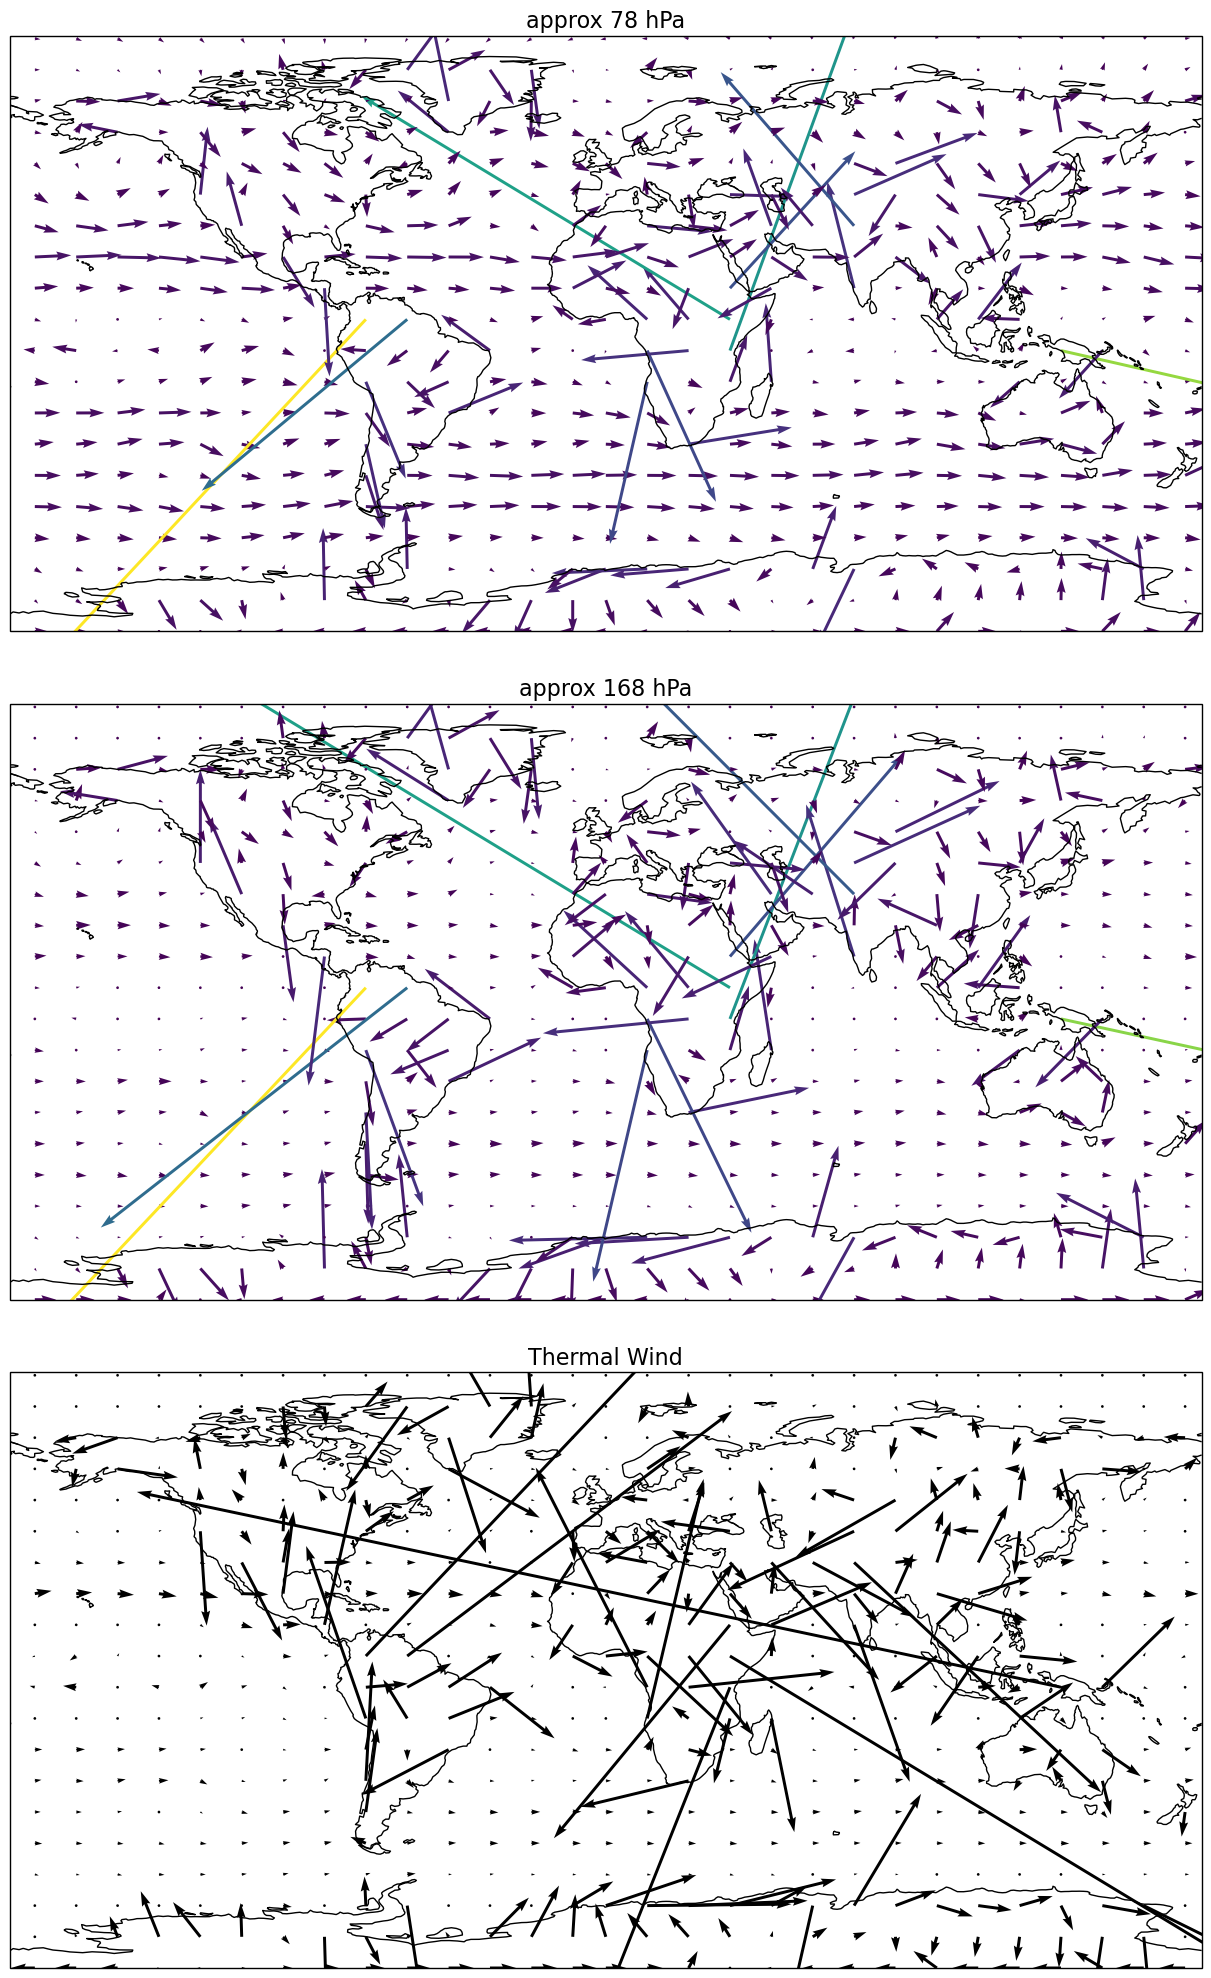

In [86]:
x = data_lev_top.lon.values[::10]
y = data_lev_top.lat.values[::10]
X, Y = np.meshgrid(x, y)
fig, axes = plt.subplots(figsize=(12, 20), nrows=3, constrained_layout=True, subplot_kw={'projection': ccrs.PlateCarree()})
ax = axes[0]
im = ax.quiver(X, Y, u_top[::10, ::10], v_top[::10, ::10], np.sqrt(u_top[::10, ::10]**2 + v_top[::10, ::10]**2), transform=ccrs.PlateCarree())
# plt.colorbar(im, ax=ax)
ax.set_title('approx 78 hPa')
ax = axes[1]
im = ax.quiver(X, Y, u_bottom[::10, ::10], v_bottom[::10, ::10],np.sqrt(u_bottom[::10, ::10]**2 + v_bottom[::10, ::10]**2),  transform=ccrs.PlateCarree())
# plt.colorbar(im, ax=ax)
ax.set_title('approx 168 hPa')
ax = axes[2]
ax.quiver(X, Y, u_t[::10, ::10], v_t[::10, ::10], transform=ccrs.PlateCarree())
ax.set_title('Thermal Wind')

for ax in axes.flat:
    ax.coastlines()
plt.show()

In [ ]:
# Mask to CONUS
us_states = regionmask.defined_regions.natural_earth_v5_0_0.us_states_50
cmip6_us = mask_data(cmip6_raw, us_states, regions=None, drop=True)
cmip6_conus = mask_data(cmip6_us, us_states, ['alaska', 'hawaii'], reverse=True, drop=True)
cmip6_conus = cmip6_conus.where(cmip6_conus.notnull(), drop=True)
smbb_us = mask_data(smbb_raw, us_states, regions=None, drop=True)
smbb_conus = mask_data(smbb_us, us_states, ['alaska', 'hawaii'], reverse=True, drop=True)
smbb_conus = smbb_conus.where(smbb_conus.notnull(), drop=True)

## Kill Dask Cluster

In [ ]:
client.shutdown()